# Homework 5: taming text

In [1]:
import pandas as pd
import numpy as np
from os import path
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import stem
from nltk.stem.wordnet import WordNetLemmatizer
import pycountry
import string

## Part 1: word clouds

We start by taking a look at the data

In [2]:
data = pd.read_csv("./hillary-clinton-emails/Emails.csv")
data.head()

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\r\nU.S. Department of State\r\nCa...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\r\nThursday, March 3, 2011 9:45 PM\r\nH: La...",UNCLASSIFIED\r\nU.S. Department of State\r\nCa...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\r\nU.S. Department of State\r\nCa...
3,4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\r\nU.S. Department of State\r\nCa...
4,5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\r\nFriday, March 1...",B6\r\nUNCLASSIFIED\r\nU.S. Department of State...


We are only interested in the content of the email, in this case the ExtractedBodyText and the ExtractedSubject.

In [3]:
data.ExtractedBodyText = data.ExtractedBodyText.fillna('')
data.ExtractedSubject = data.ExtractedSubject.fillna('')
mails = pd.DataFrame(data.ExtractedSubject + " " + data.ExtractedBodyText)
mails.columns = ['content']
print(mails.size)
mails.head()

7945


,content
0,FW: Wow
1,"B6\r\nThursday, March 3, 2011 9:45 PM\r\nH: L..."
2,Re: Chris Stevens Thx
3,FVV: Cairo Condemnation - Final
4,"H <hrod17@clintonemail.com>\r\nFriday, March ..."


In order to create the first word cloud we need to concatenate all the email content together.

In [4]:
content = mails.content.str.cat(sep=' ')
content[0:100]

'FW: Wow   B6\r\nThursday, March 3, 2011 9:45 PM\r\nH: Latest How Syria is aiding Qaddafi and more... Sid'

In [5]:
wordcloud = WordCloud().generate(content)

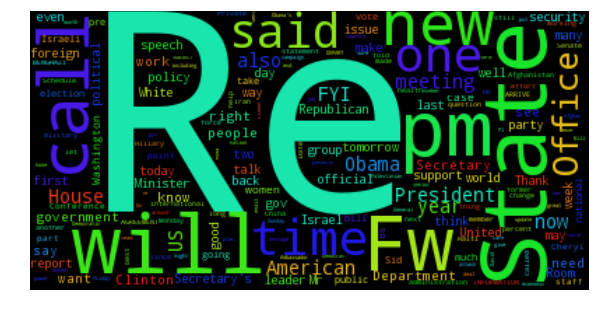

In [6]:
plt.subplots(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

We will now pre-process the text in order to remove words such as re, fw, pm, new, also, many. This way our worldcloud will contain more useful words.

### Text pre-processing

We start by **tokenizing** the text. The regex tokenizer will also remove ponctuation.

In [7]:
# nltk.download() # run this if lookup error english.pickle
pattern = r'''(?x)          # set flag to allow verbose regexps
        (?:[A-Z]\.)+        # abbreviations, e.g. U.S.A.
      | \w+(?:-\w+)*        # words with optional internal hyphens
      | \$?\d+(?:\.\d+)?%?  # currency and percentages, e.g. $12.40, 82%
      | \.\.\.              # ellipsis
      | [][.,;"'?():_`-]    # these are separate tokens; includes ], [
    '''
tokenizer = RegexpTokenizer(pattern)
tokens = tokenizer.tokenize(content)
tokens[0:10]

['FW', ':', 'Wow', 'B6', 'Thursday', ',', 'March', '3', ',', '2011']

We transform the tokens to all lowercase.

In [8]:
tokens = [x.lower() for x in tokens if x not in ['US', 'U.S.']]
tokens[0:10]

['fw', ':', 'wow', 'b6', 'thursday', ',', 'march', '3', ',', '2011']

In [9]:
len(tokens)

760650

Next we **remove stopwords**.

In [10]:
stop = stopwords.words('english') + ['re', 'fw', 'pm', 'am', 'com'] + list(string.punctuation)
tokens = [word for word in tokens if word not in stop]
tokens[0:10]

['wow', 'b6', 'thursday', 'march', '3', '2011', '9', '45', 'h', 'latest']

In [11]:
len(tokens)

376034

Next we apply **stemming**.

In [12]:
sno = stem.SnowballStemmer('english')
stemming = [sno.stem(x) for x in tokens]
stemming[0:10]

['wow', 'b6', 'thursday', 'march', '3', '2011', '9', '45', 'h', 'latest']

In [13]:
content = ' '.join(stemming)
content[0:100]

'wow b6 thursday march 3 2011 9 45 h latest syria aid qaddafi ... sid hrc memo syria aid libya 030311'

In [14]:
wordcloud = WordCloud().generate(content)

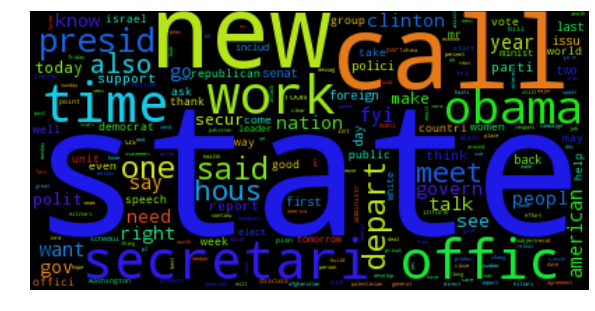

In [15]:
plt.subplots(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

This word cloud contains stems instead of actual words (e.g. offic, secratari). We now try a **lemmatizer** instead of the stemmer.

In [16]:
lmtzr = WordNetLemmatizer()
lemmas = [lmtzr.lemmatize(x) for x in tokens]
lemmas[0:10]

['wow', 'b6', 'thursday', 'march', '3', '2011', '9', '45', 'h', 'latest']

In [17]:
content = ' '.join(lemmas)
content[0:100]

'wow b6 thursday march 3 2011 9 45 h latest syria aiding qaddafi ... sid hrc memo syria aiding libya '

In [18]:
wordcloud = WordCloud().generate(content)

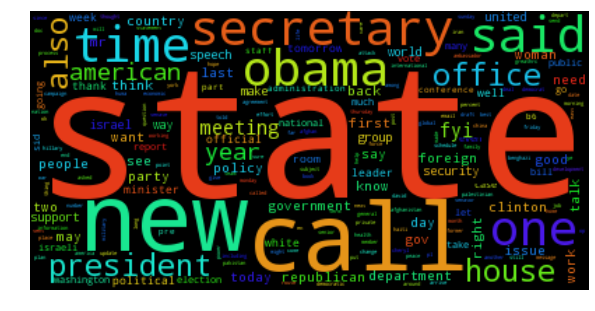

In [19]:
plt.subplots(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

We conclude that the last wordcloud is the most interesting one because the text pre-processing removed some words that didn't bring any information. And it also grouped different uses of the same word as one.

## Part 2: Sentiment analysis for countries

Let's take a look at the countries that are provided with the pycountry library.

In [20]:
pycountry.countries.get(alpha_2='SY')

Country(alpha_2='SY', alpha_3='SYR', name='Syrian Arab Republic', numeric='760')

We can see that this library will not do all the work for us. We need to figure out a way to go from 'Syrian Arab Republic' to 'Syria'. The same goes for 'Iran', 'Korea', 'Macedonia', 'Korea' and 'Tanzania'.

In [21]:
pycountry.countries.get(alpha_2='PM')

Country(alpha_2='PM', alpha_3='SPM', name='Saint Pierre and Miquelon', numeric='666')

We also need to be carefull with the use of the acronyms such as 'PM', 'AM', 'COM'. United kingdom should also be 'UK'.

We decide to make some changes to the provided library:
- 'Syrian Arab Republic' is changed to 'Syria'.
- whenever a country name contains a ',' with drop everything after ','
- We add UK as an acronym for United Kingdom

In [22]:
countries = list(pycountry.countries)
for country in countries:
    if 'Syria' in country.name:
        country.name = 'Syria'
    if ',' in country.name:
        country.name = country.name.split(',', 1)[0]
    if country.alpha_3 == 'GBR':
        country.alpha_3 = 'UK'

We define a function that for each email content will match the content to the countries that are mentioned in the email. We add acronyms to the stopwords because this list will otherwise be identified with a country.

In [23]:
def lookup_countries(content):
    c = []
    # transform content into tokens
    tok = tokenizer.tokenize(content)
    stop = stopwords.words('english') + ['re', 'fw', 'pm', 'am', 'com', 'fm', 'om', 'mr', 'ms', 'st', 'ben', 'cc', 'tv', 'guy'] + list(string.punctuation)
    tok = [word for word in tok if word.lower() not in stop]
    tok = [x.upper() for x in tok if x not in ['us']]
    for i in range(0,len(tok)):
        tok[i] = ''.join(ch for ch in tok[i]if ch not in '.')
        
    # check if tokens correspond to countries
    for country in countries:
        if country.name.lower() in content.lower():
            c.append(country.name)
        if country.alpha_2 in tok or country.alpha_3 in tok:
            c.append(country.name)
    return list(set(c))  

In [24]:
lookup_countries('hello U.S.A., I am from Belgium')

['United States', 'Belgium']

In [25]:
mails['countries'] = mails['content'].apply(lookup_countries)
mails.head(10)

,content,countries
0,FW: Wow,[]
1,"B6\r\nThursday, March 3, 2011 9:45 PM\r\nH: L...","[Libya, Syria]"
2,Re: Chris Stevens Thx,[]
3,FVV: Cairo Condemnation - Final,[]
4,"H <hrod17@clintonemail.com>\r\nFriday, March ...","[Libya, Syria]"
5,Meet The Right Wing Extremist Behind Anti-Musl...,[United States]
6,"FW: Anti-Muslim film director in hiding, follo...","[Libya, Egypt]"
7,"H <hrod17@clintonemail.corn>\r\nFriday, March...","[Libya, Syria]"
8,FVV: Secretary's remarks FYI,[]
9,"more on Libya B6\r\nWednesday, September 12, 2...",[Libya]


In [26]:
mails.iloc[6].content

'FW: Anti-Muslim film director in hiding, following Libya, Egypt violence '

Let's take a look at the countries that are mentioned in the emails.

In [27]:
all_countries = []
for c in mails['countries']:
    all_countries = all_countries + c
all_countries[:10]

['Libya',
 'Syria',
 'Libya',
 'Syria',
 'United States',
 'Libya',
 'Egypt',
 'Libya',
 'Syria',
 'Libya']

We remove all the countries that are mentioned less than 25 times

In [28]:
country_counts = pd.Series(all_countries).value_counts()
print(country_counts.size)
country_counts = country_counts[country_counts > 25]
print(country_counts.size)

211
44


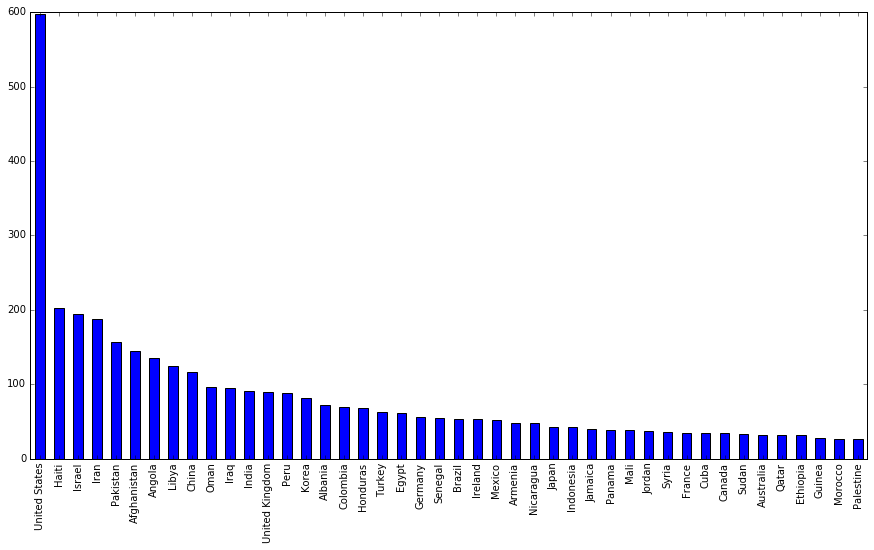

In [29]:
plt.figure(figsize=(15,8))
country_counts.plot(kind='bar')